6.1.3 TD法の実装

In [3]:
from collections import defaultdict
import numpy as np

class TdAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.01
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def eval(self, state, reward, next_state, done):
        next_V = 0 if done else self.V[next_state]
        target = reward + self.gamma * next_V # 行動先の即時報酬+次の状態の価値関数 = 現在の状態価値の推定値(ターゲット)

        self.V[state] += (target - self.V[state]) * self.alpha # そのターゲットにα分だけ更新

In [4]:
action_probs = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
actions = list(action_probs.keys())
print(actions)

[0, 1, 2, 3]


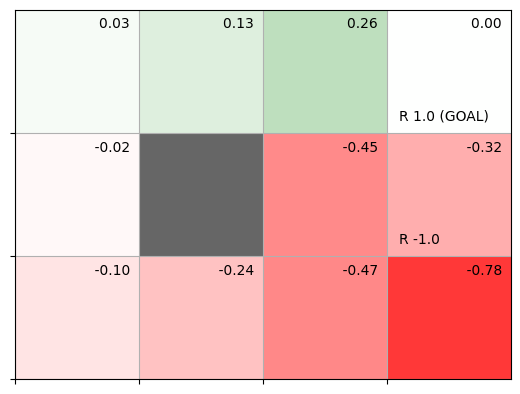

In [5]:
from common.gridworld import GridWorld

env = GridWorld()
agent = TdAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.eval(state, reward, next_state, done) # 現在の状態の価値更新
        if done:
            break
        state = next_state

env.render_v(agent.V)


6.2.2 SARSAの実装

In [6]:
from collections import defaultdict, deque
import numpy as np
from common.utils import greedy_probs

class SarsaAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2) # 先入先出（直近の経験データ２つを保持）

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2: # 経験が２つ未満（SARSAにおける二つ目のSAがまだない：序盤）
            return

        state, action, reward, done = self.memory[0] # 現在の状態における行動とその即時報酬(SAR)
        next_state, next_action, _, _, = self.memory[1] # 次の状態とそこからの行動(SA)

        next_q = 0 if done else self.Q[next_state, next_action] # 次の状態がゴールならその価値は０、ゴールでなければQマップから参照

        # 現在の状態のある行動における価値を推定し、α分更新
        target = reward + self.gamma * next_q
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        # 方策を更新（制御）：現在の状態において最も価値の高い行動を最も高い確率で選択する方策
        self.pi[state] = greedy_probs(self.Q, state, self.epsilon) # e.g {0: 0.25, 1: 0.925, 2: 0.25, 3: 0.25}


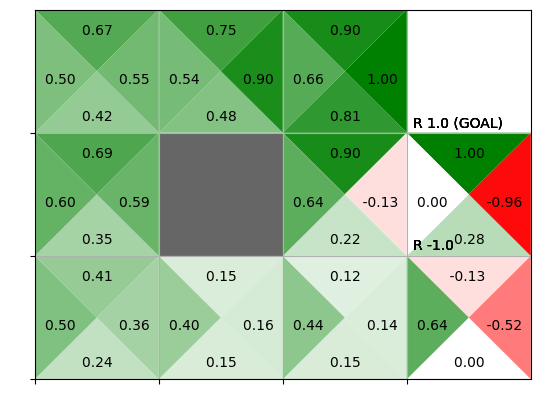

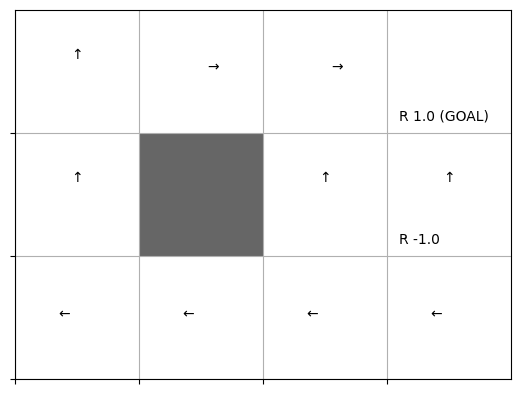

In [7]:
from common.gridworld import GridWorld

env = GridWorld()
agent = SarsaAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset() # エージェントの座標を初期化
    agent.reset() # 経験を削除

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done: # 次の状態がゴールならもう一度連続で更新
            agent.update(next_state, None, None, None) # ゴールが現在の状態の時、次の行動や即時報酬や完了フラグは不要
            break
        state = next_state

env.render_q(agent.Q)

6.3.2 方策オフ型のSARSAの実装

In [8]:
from collections import defaultdict, deque

class SarsaOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions) # ターゲット方策（最適方策：活用） e.g. {0: 0.025, 1: 0.925, 2: 0.025, 3: 0.025}
        self.b = defaultdict(lambda: random_actions) # 挙動方策(エージェントの実際の行動：探索) e.g. {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)

    def get_action(self, state):
        action_probs = self.b[state] # 挙動方策から行動を取得
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return

        state, action, reward, done = self.memory[0] # done: 次の状態がゴールかどうかのフラグ
        next_state, next_action, _, _ = self.memory[1]

        if done: # もし次の状態がゴールなら
            next_q = 0 # 次の状態の行動価値は０
            rho = 1 # 重みを１（価値をそのまま使う）
        else:
            next_q = self.Q[next_state, next_action] # このQ値(next_q)は挙動方策bで取得したものだから実際にQ値の推定値を求めるとき補正が必要
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action] # ターゲット方策と挙動方策の比率（ターゲット方策における確率の高い行動の場合より大きな重みを与える＝より大きく推定値（Q値）を変動させる）

        target = rho * (reward + self.gamma * next_q) # 重点サンプリングを適用させ補正した現在の状態価値の推定値（ターゲット）：
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha # Q値をα分だけ更新

        # 方策を更新（制御）：現在の状態においてQ値を参照し、それぞれの方策を更新
        self.pi[state] = greedy_probs(self.Q, state, 0) # 活用のみ(greedy) e.g {0: 0, 1: 1.0, 2: 0, 3: 0}
        self.b[state] = greedy_probs(self.Q, state, self.epsilon) # 探索と活用(ε-greedy)　e.g {0: 0.25, 1: 0.925, 2: 0.25, 3: 0.25}


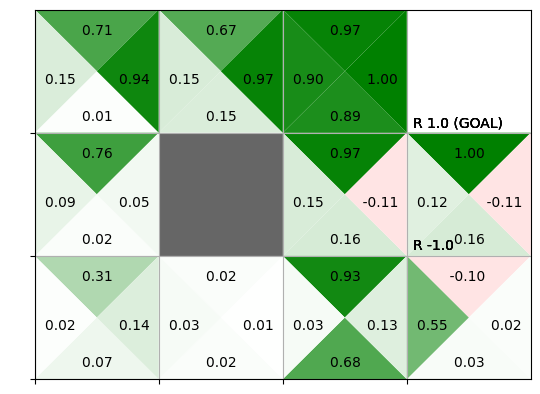

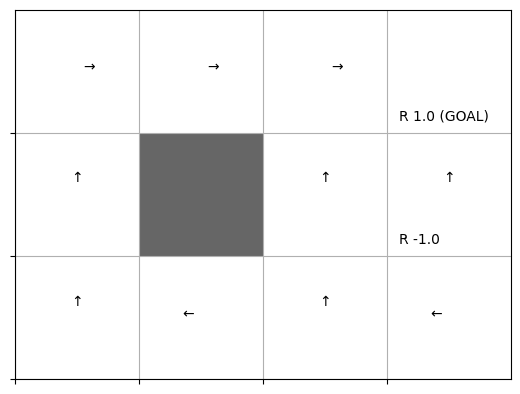

In [9]:
from common.gridworld import GridWorld

env = GridWorld()
agent = SarsaOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset() # エージェントの座標を初期化
    agent.reset() # 経験を削除

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done: # 次の状態がゴールならゴール状態を代入してその前の状態を更新して終了
            agent.update(next_state, None, None, None) # ゴールが現在の状態の時、次の行動や即時報酬や完了フラグは不要
            break
        state = next_state

env.render_q(agent.Q)

6.4.3 Q学習の実装

In [10]:
from collections import defaultdict
import numpy as np
from common.gridworld import GridWorld
from common.utils import greedy_probs

# エージェントの行動は挙動方策に従うが、Q値の計算には挙動方策が関与しないため補正（重点サンプリング）が必要ない
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.b[state] # 挙動方策(探索と活用： ε-greedy)に基づいて行動を取得
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        if done: # 次の状態がゴールなら
            next_q_max = 0 # 次の状態の価値は0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)] # 次の状態における全行動の価値をリストに格納
            next_q_max = max(next_qs) # 最大の価値を取得（＝挙動方策bが関与しない）

        target = reward + self.gamma * next_q_max # 次の状態における最大価値を使って推定値を計算（＝この計算に挙動方策bが関与しないため補正が必要ない）
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha # α分だけ更新

        # 方策更新
        self.pi[state] = greedy_probs(self.Q, state, 0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)


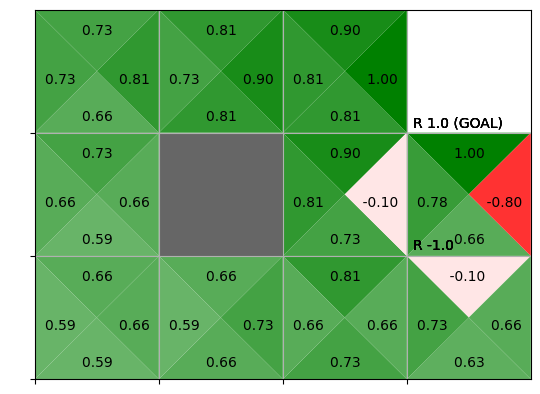

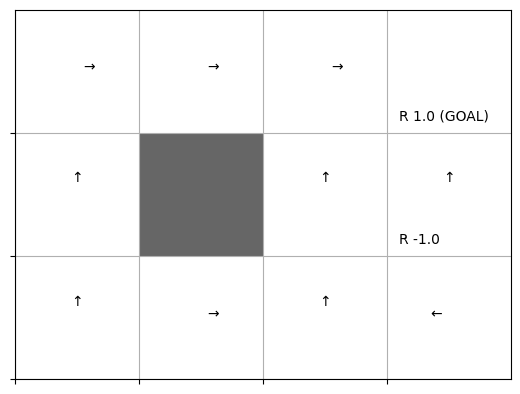

In [11]:
from common.gridworld import GridWorld

env = GridWorld()
agent = QLearningAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset() # エージェントの座標を初期化
    # agent.reset() # 経験を削除

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward,next_state, done)

        if done: # 次の状態がゴールなら即終了
            break
        state = next_state

env.render_q(agent.Q)

6.5.1 分布モデルとサンプルモデル

In [12]:
from collections import defaultdict
import numpy as np
class RandomAgent:
    def __init__(self):
        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25} # 確率分布
        self.pi = defaultdict(lambda: random_actions)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs) # サンプリング


6.5.2 サンプルモデル版のQ学習

In [13]:
from collections import  defaultdict
import numpy as np
from common.utils import greedy_probs

class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        # random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25} #　確率分布は不要
        # self.pi = defaultdict(lambda: random_actions) # ターゲット方策を削除（結局現状では、render_Qでself.Qを参照してgreedyな方策を求めているからこのself.piは使われない）
        # self.b = defaultdict(lambda: random_actions) # 挙動方策はε-greedyそのままだから、get_actionsでε-greedyを使用
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        # 分布モデルでは挙動方策bを基に行動選択したが、実質ε-greedyだからここでそのままε-greedyの仕様にする
        if  np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = [self.Q[state, a] for a in range(self.action_size)]
            return np.argmax(qs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha



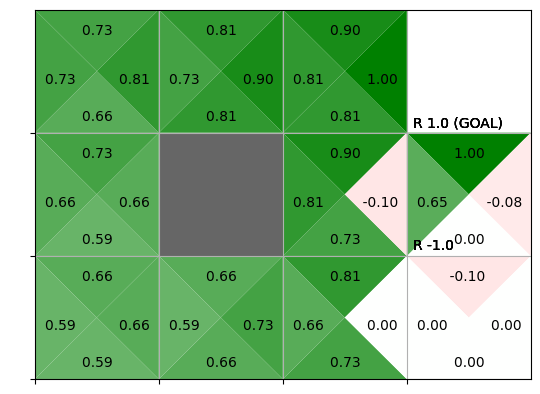

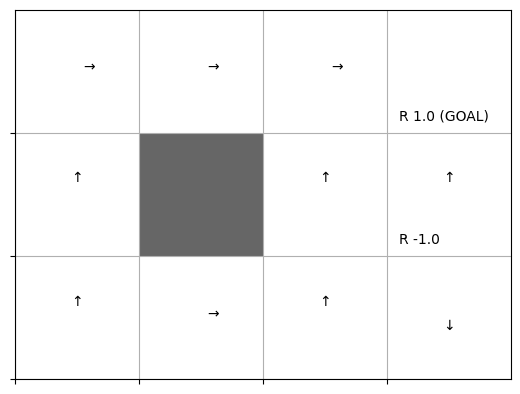

In [14]:
from common.gridworld import GridWorld

env = GridWorld()
agent = QLearningAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)
        if done:
            break
        state = next_state

env.render_q(agent.Q)
